Initialization paths...
All paths was initialized.
Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv
Loading & preparing image data...

Cropping & loading labels by 1st image:
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.
Crop labels is done.

Resizing images by 1st label:
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/images/reg_64_2020_06_90d_comp.b.tif
Files was loaded.
Loading from cache...
Loading file: /Users/stephenhawking/Coding/ML/lo

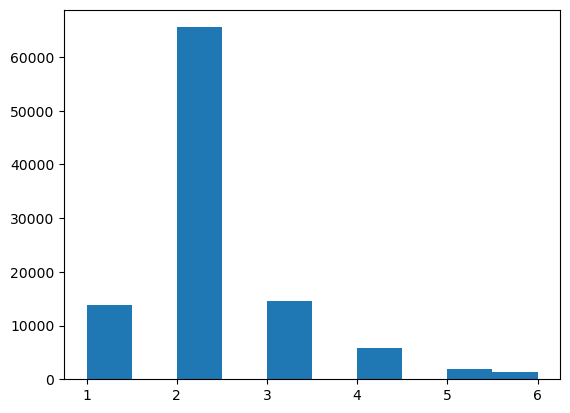

In [1]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *

downgrade_labels = False
force = False


if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")

labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

year = 2020
only_bands = ["r", "b", "g", "n"]
mask_mode = "secure"
stratify = True
r = 2
count_assign = 0.05

signs_paths = signs.query(
    f"year == {year} and season == '90d' and band in @only_bands"
).sort_values("band")
signs_paths = signs_paths["path"].to_list()
labels_paths = labels.query(f"year == {year}")["path"].to_list()

z_x, z_y, x, y = generate_dataset(
    signs_paths,
    labels_paths,
    count_assign,
    mask_mode=mask_mode,
    r=r,
    stratify=stratify,
    force=force,
)

uniq_type, uniq_count = np.unique(z_y, return_counts=True)
print(uniq_type, uniq_count)
plt.hist(z_y)
plt.show()

In [2]:
m, m_rep, m_cm, f1 = train_model(z_x, z_y)
m

Split X, y -> X_train, y_train...
Start training model...
Selected model / method: RF
Model was trained. Start validate it...

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.90      0.88      2562
           2       0.84      0.94      0.89     12852
           3       0.42      0.16      0.23      2649
           4       0.99      1.00      0.99       951
           5       0.64      0.29      0.40       150
           6       0.50      0.33      0.40         6

    accuracy                           0.82     19170
   macro avg       0.71      0.60      0.63     19170
weighted avg       0.79      0.82      0.80     19170

Confusion Matrix:
[[ 2309   221    27     4     1     0]
 [  227 12081   535     2     7     0]
 [  137  2069   426     3    14     0]
 [    1     2     0   948     0     0]
 [    1    70    31     3    43     2]
 [    0     2     0     0     2     2]]
Saving model...
Model was saved: /Users/stephenhawking

RandomForestClassifier(random_state=42)

In [3]:
# Mapping by RAM tensor-images (230m) (for fast learn it!)
out = f"230_map_{mask_mode}_{count_assign}.tif"
create_map(x, m, out)

Reshaping tensor-images...
Start create of map...

map size: x = 1421, y = 1349, bands = 4, total px=1916929


Creating map...: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]

Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/0.2min_230_map_secure_0.05.tif


'/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/0.2min_230_map_secure_0.05.tif'

In [20]:
# Mapping by loaded images from path (10m)

only_bands = ["r", "b", "g", "n"]

tiles = DEFAULT_PATH["images"] + "tiles/"
tiles = parse_tifs_from(tiles, typeof="tile")
tiles = tiles.query("band in @only_bands").sort_values("band")["path"]
tiles = tiles.to_list()

loaded_tiles = []
for t in tiles:
    loaded_tiles.append(load_tif(t, only_first=True))

Load 'tile' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b2_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b3_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b8_l2a_med.frag.0.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/tiles/comp_s2_90d_b4_l2a_med.frag.0.tif
Files was loaded.


In [17]:
out = f"handle_map_10m_{mask_mode}_{count_assign}.tif"
predicted = create_map(loaded_tiles, m, out)

Reshaping tensor-images...
Start create of map...

map size: x = 10980, y = 10980, bands = 4, total px=120560400


Creating map...: 100%|██████████| 58/58 [22:54<00:00, 23.70s/it]


Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_random_12000.tif


In [18]:
# Module: validation
from validation import *

year = 2020
map = "wc"

# predicted = "/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_0.05.tif"
etalons = DEFAULT_PATH["etalons"]
etalons = parse_tifs_from(etalons, typeof="etalon")
etalons = etalons.query(f"year == {year} and map =='{map}'")["path"].to_list()
r = validate_how_tif(predicted, etalons, year=2020, map="wc")
create_diff_map(predicted, etalons[0], "positive")
create_diff_map(predicted, etalons[0], "negative")

Load 'etalon' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_etalon.csv
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_random_12000.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_random_12000.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/positive_handle_map_10m_random_12000.tif
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_random_12000.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/negative_handle_map_10m_random_12000.tif


In [19]:
create_diff_map(predicted, etalons[0], "negative")

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/handle_map_10m_random_12000.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.
(10980, 10980)
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/negative_handle_map_10m_random_12000.tif


In [20]:
r

{'wc': {'class_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       0.32      0.85      0.47   4469617\n           2       0.82      0.71      0.76  82684206\n           3       0.42      0.41      0.41  30124044\n           4       0.54      0.91      0.68   2276691\n           5       0.27      0.67      0.38    835544\n           6       0.02      0.10      0.03    170298\n\n    accuracy                           0.64 120560400\n   macro avg       0.34      0.52      0.39 120560400\nweighted avg       0.69      0.64      0.66 120560400\n',
  'conf_matrix': array([[       0,        0,        0,        0,        0,        0,
                 0],
         [   21053,  3815190,    57505,   249490,   267236,    45093,
             14050],
         [  533395,  4625542, 58394941, 17084260,   855334,   695648,
            495086],
         [  164264,  3225334, 12482763, 12459385,   605602,   757303,
     

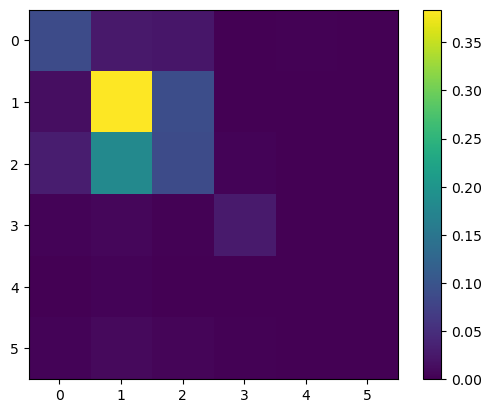

1800


In [22]:
plot_confusion(m_cm / m_cm.sum())
print(m_cm.sum())

In [23]:
print(m_rep)

              precision    recall  f1-score   support

           1       0.63      0.63      0.63       252
           2       0.63      0.79      0.70       879
           3       0.42      0.29      0.34       544
           4       0.81      0.70      0.75        71
           5       0.33      0.14      0.20        14
           6       0.50      0.03      0.05        40

    accuracy                           0.59      1800
   macro avg       0.55      0.43      0.45      1800
weighted avg       0.57      0.59      0.57      1800



In [25]:
z_y

array([3, 2, 1, ..., 3, 3, 3], dtype=uint8)

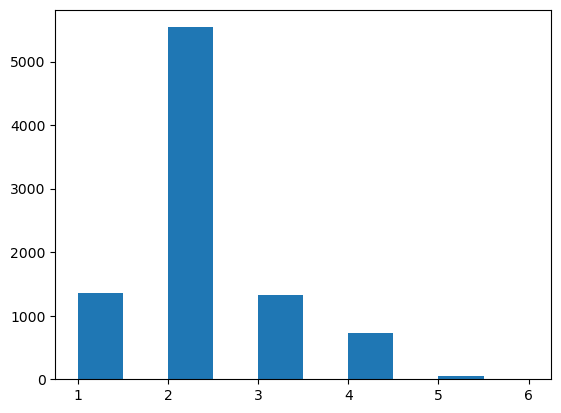

In [6]:
uniq_type, uniq_count = np.unique(z_y, return_counts=True)
uniq_type, uniq_count
plt.hist(z_y)
plt.show()